# Test

## Imports

In [138]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
import mmfsim.beams as beams
from mmfsim.fiber import StepIndexFiber
from mmfsim.modes import StepIndexLPMode
from mmfsim.speckle import StepIndexSpeckle, DegenStepIndexSpeckle
from mmfsim.coupling import GrinFiberCoupler, StepIndexFiberDegenCoupler, StepIndexFiberCoupler
from mmfsim.devices import MockDeformableMirror
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create a beam on a 2D grid

In [170]:
grid = Grid(pixel_size=0.5e-6, pixel_numbers=(128,128))
fiber = StepIndexFiber(radius=26e-6, wavelength=632e-9, n1=1.465, n2=1.445)
coupling_matrix = fiber.modes_coupling_matrix(complex=complex, full=True, degen=True)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:176: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:177: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 26.0 um
  - Core index: 1.465
  - Cladding index: 1.445
  - Wavelength: 632.0 nm
  - Numerical aperture: 0.241
  - Number of guided LP modes: 502
  - Number of guided LP modes (counting degenerates): 984
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46497138  0.          0.          1.        ]
 [ 1.46492735  2.          1.          1.        ]
 [ 1.46486949  4.          2.          1.        ]
 [ 1.46484922  1.          0.          2.        ]
 [ 1.46479857  6.          3.          1.        ]
 [ 1.46475646  3.          1.          2.        ]
 [ 1.46471506  8.          4.          1.        ]
 [ 1.46464941  5.          2.          2.        ]
 [ 1.46462944  2.          0.          3.        ]
 [ 1.46461927 10.          5.          1.        ]]


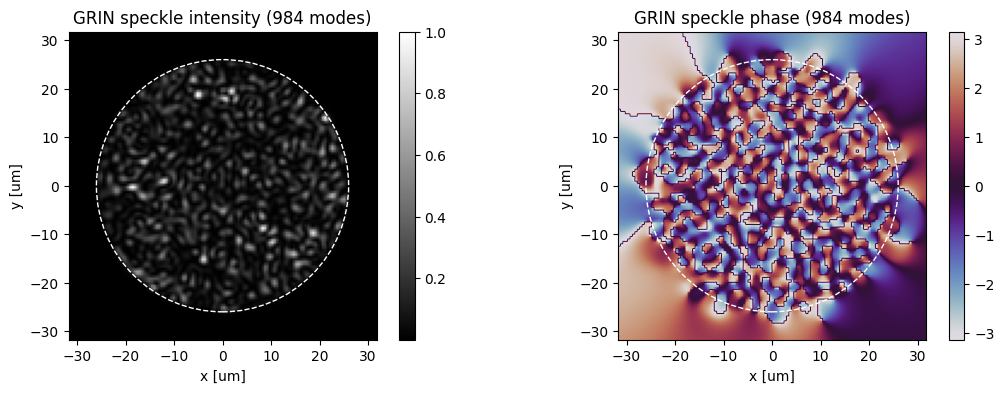

In [171]:
speckle = DegenStepIndexSpeckle(fiber, grid, N_modes=fiber._N_modes_degen)
speckle.compose()
_ = speckle.plot(complex=True)

### Gaussian beam limited by a deformable mirror with macro-pixel phases, without separating degenerated modes

Coupled energy: 0.8109087698259716


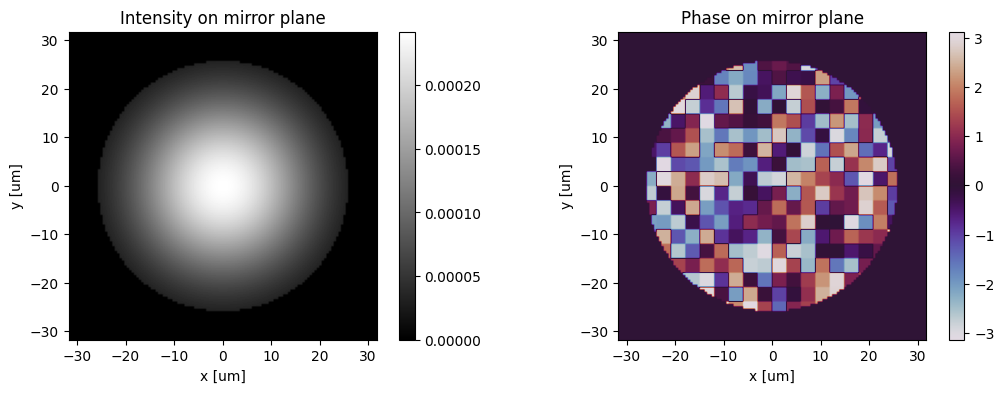

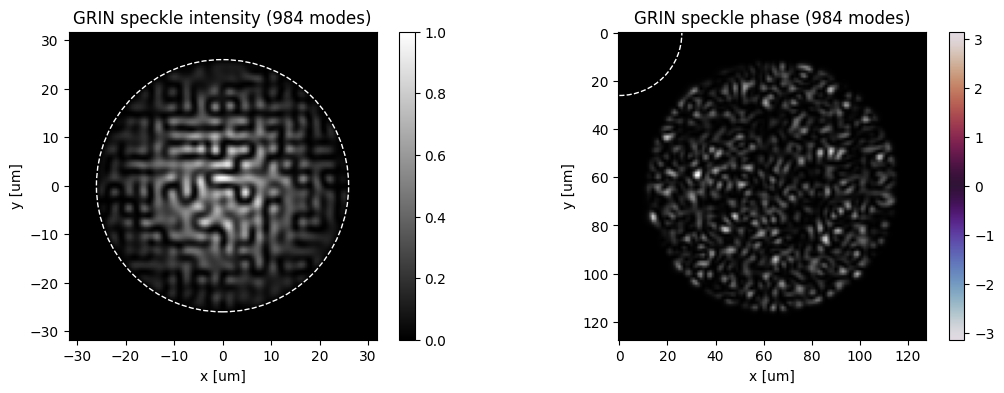

In [176]:
phases_dim = (20,20)

dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2*fiber.radius)
beam = beams.GaussianBeam(grid)
beam.compute(width=fiber.radius)
beam.normalize_by_energy()
dm.apply_amplitude_map(beam.amplitude)

phase_map = -np.pi + 2*np.pi*np.random.rand(*phases_dim)
dm.apply_phase_map(phase_map)
beam.field = dm._field_matrix

dm.plot()


coupled_in = StepIndexFiberDegenCoupler(beam.field, beam.grid, fiber, N_modes=fiber._N_modes_degen)
print(f"Coupled energy: {coupled_in.energy}")
coupled_in.plot(cmap='gray', complex=True)
propagated_field = coupled_in.propagate(matrix=coupling_matrix)

plt.imshow(np.square(np.abs(propagated_field)), cmap='gray')